<a href="https://colab.research.google.com/github/sznajder/Lectures/blob/master/modMLP_HZZ4l_Keras_softmax_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for HZZ4l analysis using  Keras
Authors: Javier Duarte, Thong Nguyen     
Modified: Andre Sznajder

## **Mount Google Drive**

In [55]:
!fusermount -u drive
!pip install uproot

fusermount: failed to unmount /content/drive: No such file or directory


In [56]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


#Load data using PANDAS data frames#
Now we load two different `NumPy` arrays. One corresponding to the VBF H->ZZ->4l signal and the other one corresponds to the QCD ZZ->4l background .

In [57]:
import uproot
import numpy as np
import pandas as pd
import h5py

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

upfile = {}
params = {}
df = {}
filename = {}

# Data dir
data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'
#!ls '/content/gdrive/My Drive/Colab Notebooks/Data'

filename['sig'] = data_dir+'ntuple_qqH_ZZ4mu.root'
filename['bkg'] = data_dir+'ntuple_bkg_ZZ4mu.root'

treename = 'HZZ4LeptonsAnalysisReduced'

upfile['sig'] = uproot.open(filename['sig'])
upfile['bkg'] = uproot.open(filename['bkg'])

# Print all tree variables
upfile['sig'][treename].show()


# Variables from Roottree to be copyed to PANDA dataframe
VARS = ['f_lept1_pt','f_lept1_eta','f_lept1_phi', \
        'f_lept2_pt','f_lept2_eta','f_lept2_phi', \
        'f_lept3_pt','f_lept3_eta','f_lept3_phi', \
        'f_lept4_pt','f_lept4_eta','f_lept4_phi', \
        'f_jet1_pt','f_jet1_eta','f_jet1_phi', \
        'f_jet2_pt','f_jet2_eta','f_jet2_phi',\
        'f_weight','f_mass4l','f_massjj','f_deltajj']
        

# Convert the Root branches/leaves directly to Pandas dataframe 
df['sig'] = upfile['sig'][treename].pandas.df(VARS)
df['bkg'] = upfile['bkg'][treename].pandas.df(VARS)

print(len(df['sig']))
print(len(df['bkg']))


# Convert the Root branches/leaves to dictionaries of Numpy arrays 
#data['sig'] = upfile['sig'][treename].arrays(VARS,namedecode="ascii")
#data['bkg'] = upfile['bkg'][treename].arrays(VARS,namedecode="ascii")
# Convert disctionary of arrays into Pandas dataframe
#df['sig'] = pd.DataFrame(data=data['sig'],columns=VARS)
#df['bkg'] = pd.DataFrame(data=data['bkg'],columns=VARS)

# Crop the background sample to have the same number of events as the signal sample
#df['bkg']=df['bkg'][:len(df['sig'])]

# Remove undefined variable entries VARS[i] <= -999
#for i in range(len(VARS)): 
#  df['sig'] = df['sig'][(df['sig'][VARS[i]] > -999)]
#  df['bkg']= df['bkg'][(df['bkg'][VARS[i]] > -999)]


f_run                      (no streamer)              asdtype('>i4')
f_lumi                     (no streamer)              asdtype('>i4')
f_event                    (no streamer)              asdtype('>i4')
f_weight                   (no streamer)              asdtype('>f4')
f_int_weight               (no streamer)              asdtype('>f4')
f_pu_weight                (no streamer)              asdtype('>f4')
f_eff_weight               (no streamer)              asdtype('>f4')
f_lept1_pt                 (no streamer)              asdtype('>f4')
f_lept1_eta                (no streamer)              asdtype('>f4')
f_lept1_phi                (no streamer)              asdtype('>f4')
f_lept1_charge             (no streamer)              asdtype('>f4')
f_lept1_pfx                (no streamer)              asdtype('>f4')
f_lept1_sip                (no streamer)              asdtype('>f4')
f_lept2_pt                 (no streamer)              asdtype('>f4')
f_lept2_eta                (no str

## **Specify the number of NN input variables **

In [58]:

# Define the NN input variables ( don't use  'f_weight', 'f_mass4l','f_massjj','f_deltajj' as inputs ! )
#NINPUT = len(VARS)-1
NINPUT = len(VARS)-4
print("NINPUT=",NINPUT)


('NINPUT=', 18)


## Define the model using KERAS functional API 
We'll start with a dense (fully-connected) NN layer.
Our model will have a single fully-connected hidden layer with the same number of neurons as input variables. 
The output layer contains a single neuron using a sigmoid activation in order to a number between 0 and 1 to make binary classification

We are using the `binary_crossentropy` loss function during training, a standard loss function for binary classification problems. 
We will optimize the model with the Adam algorithm for stochastic gradient descent and we will collect accuracy metrics while the model is trained.

In [59]:
# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.layers import Input, Activation, Dense, Dropout
from keras.utils import np_utils
from keras.layers import Lambda , concatenate
from keras import backend

def swish(x):
    return backend.sigmoid(x) * x

def crop(dimension, start, end):
    # Crops (or slices) a Tensor on a given dimension from start to end
    # example : to crop tensor x[:, :, 5:10]
    # call slice(2, 5, 10) as you want to crop on the second dimension
    def func(x):
        if dimension == 0:
            return x[start: end]
        if dimension == 1:
            return x[:, start: end]
        if dimension == 2:
            return x[:, :, start: end]
        if dimension == 3:
            return x[:, :, :, start: end]
        if dimension == 4:
            return x[:, :, :, :, start: end]
    return Lambda(func)
  
# Select the NN input variables. Using just lepton and and jets 4-mom ( low level veriables) ! 
input  = Input(shape=(NINPUT,), name = 'input') 

# Slice the input into leptons and put feed first lepton pair layer 
input_lept1 = crop(1,0,5)(input)
hidden_lept1 = Dense(4, name = 'hidden_lept1', kernel_initializer='normal', activation='relu')(input_lept1)

# Slice the input into leptons and put feed second lepton pair layer 
input_lept2 = crop(1,6,11)(input)
hidden_lept2 = Dense(4, name = 'hidden_lept2', kernel_initializer='normal', activation='relu')(input_lept2)

# Slice the input to feed first jet layer 
input_jet  = crop(1,12,18)(input)
hidden_jet = Dense(4, name = 'hidden_jet1', kernel_initializer='normal', activation='relu')(input_jet)

# Concatenate the lepton and jet layers into a single hidden layer
hidden = concatenate([hidden_lept1,hidden_lept2,hidden_jet])

hidden  = Dense(10, name = 'hidden1', kernel_initializer='normal', activation='relu')(hidden)

# Define the a single node output layer
#output  = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
output  = Dense(2      , name = 'output', kernel_initializer='normal', activation='softmax')(hidden)

# create the model
model = Model(inputs=input, outputs=output)

# Define the optimizer ( minimization algorithm )

#optim = SGD(lr=0.01,decay=1e-6)
optim = Adam(lr=0.001)

# compile the model
#model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 18)           0                                            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 5)            0           input[0][0]                      
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 6)            0           input[0][0]                      
__________________________________________________________________________________________________
hidden_lep

## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing). 


In [60]:
# Add the variable isSignal to the dataframe containing the signal and background events
df['sig']['isSignal'] = np.ones(len(df['sig'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 


# Renormalizes the events weights to give unit sum in the signal and background dataframes
# This is necessary for the NN to learn signal and background in the same proportion , 
#   independently of number of events and absolute weights of events in each sample !
df['sig']['f_weight']=df['sig']['f_weight']/df['sig']['f_weight'].sum(axis=0)
df['bkg']['f_weight']=df['bkg']['f_weight']/df['bkg']['f_weight'].sum(axis=0)


# Concatanate the signal and background in a single  data frames 
df_all = pd.concat([df['sig'],df['bkg']])

# Transform the data frame into a 2-dim numpy array and get the target output ( last entry )
NVARS=len(VARS)
print("NVARS=",NVARS)
dataset = df_all.values

# Random shuffles the dataset to mix signal and background events before splitting between train and test samples
np.random.shuffle(dataset)

X = dataset[:,0:NVARS]
Y = dataset[:,-1]
Y = np_utils.to_categorical(Y, 2)

print("X=",X)
print("Y=",Y)

# Split the sample into train and test  
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

# Get events weights
weights=X_train_val[:,19]

print("Signal Max Weight=",df['sig']['f_weight'].max(axis=0))
print("Signal Min Weight=",df['sig']['f_weight'].min(axis=0))
print("Background Max Weight=",df['bkg']['f_weight'].max(axis=0))
print("Background Min Weight=",df['bkg']['f_weight'].min(axis=0))


('NVARS=', 22)
('X=', array([[ 3.07505798e+01,  1.27437901e+00,  1.70030582e+00, ...,
         1.23047890e+02,  3.71148590e+02,  3.25640655e+00],
       [ 9.07513962e+01, -1.39704609e+00,  2.90116251e-01, ...,
         2.24068634e+02, -9.99000000e+02, -9.99000000e+02],
       [ 2.92876720e+01, -6.75566435e-01,  5.11648715e-01, ...,
         1.84038193e+02, -9.99000000e+02, -9.99000000e+02],
       ...,
       [ 3.97392197e+01,  1.16534248e-01,  9.64513361e-01, ...,
         2.26275879e+02, -9.99000000e+02, -9.99000000e+02],
       [ 4.06560936e+01,  1.16614148e-01, -2.44402003e+00, ...,
         4.38854248e+02, -9.99000000e+02, -9.99000000e+02],
       [ 6.13348198e+01, -7.74336517e-01, -2.67291594e+00, ...,
         1.97752396e+02, -9.99000000e+02, -9.99000000e+02]]))
('Y=', array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32))
('Signal Max Weight=', 9.9976496e-05)
('Signal Min Weight=', 5.067209e-08)
('Backg

## Run NN Training 


In [61]:
# Number of training epochs
nepochs=20 
# Batch size
batch=10
# Train classifier
history = model.fit(X_train_val[:,0:NINPUT], 
                    Y_train_val, 
                    epochs=nepochs, 
                    batch_size=batch, 
                    verbose=1, # switch to 1 for more verbosity 
                    validation_split=0.2)

Train on 53711 samples, validate on 13428 samples
Epoch 1/20
53711/53711 [==============================] - 10s 195us/step - loss: 0.2196 - acc: 0.9273 - val_loss: 0.2022 - val_acc: 0.9339
Epoch 2/20
53711/53711 [==============================] - 9s 176us/step - loss: 0.2081 - acc: 0.9301 - val_loss: 0.1999 - val_acc: 0.9336
Epoch 3/20
53711/53711 [==============================] - 9s 173us/step - loss: 0.1987 - acc: 0.9307 - val_loss: 0.1891 - val_acc: 0.9331
Epoch 4/20
53711/53711 [==============================] - 9s 175us/step - loss: 0.1951 - acc: 0.9311 - val_loss: 0.1907 - val_acc: 0.9339
Epoch 5/20
53711/53711 [==============================] - 9s 169us/step - loss: 0.1942 - acc: 0.9317 - val_loss: 0.1877 - val_acc: 0.9333
Epoch 6/20
53711/53711 [==============================] - 9s 173us/step - loss: 0.1933 - acc: 0.9309 - val_loss: 0.1901 - val_acc: 0.9331
Epoch 7/20
53711/53711 [==============================] - 10s 178us/step - loss: 0.1930 - acc: 0.9313 - val_loss: 0.2311 

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

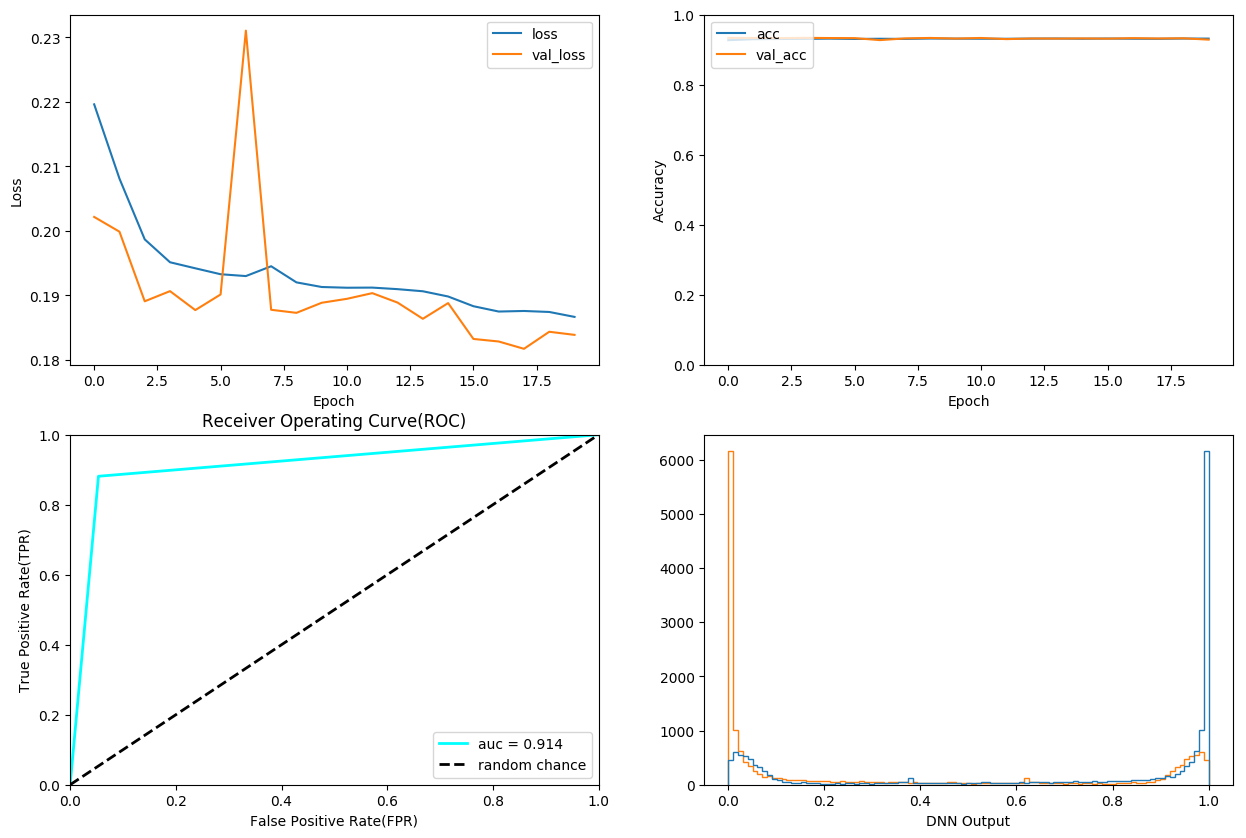

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain the NN predictions for test sample
Y_predict = model.predict(X_test[:,0:NINPUT])


plt.style.use('default')
plt.figure(figsize=(15,10))

# plot loss vs epoch
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
#ax.set_ylim([0, 1])
ax.legend(loc="upper right")
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
ax.plot(history.history['acc'], label='acc')
ax.plot(history.history['val_acc'], label='val_acc')
ax.set_ylim([0, 1.0])
ax.legend(loc="upper left")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(Y_test,axis=1), np.argmax(Y_predict,axis=1))
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('Receiver Operating Curve(ROC)')
ax.legend(loc="lower right")

# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 100)
ax.hist(Y_predict, bins=X, label='bkg',histtype='step')
#ax.hist(Y_train_val, bins=X, label='bkg',histtype='step')

ax.set_xlabel('DNN Output')

plt.show()

# Plot  $m_{jj}$, $\Delta\eta_{jj}$ and $m_{4l}$  for NN output > cut to show that the NN did learned the physics !


0.881326352531
0.504453441296


(50, 400)

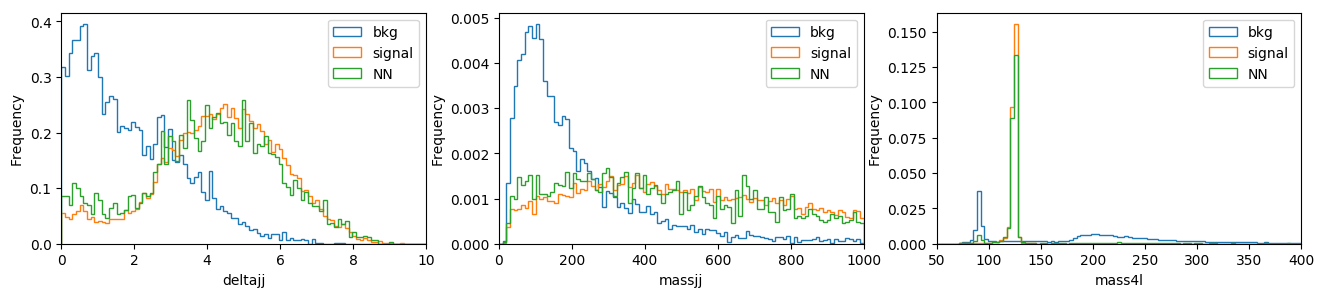

In [63]:
import matplotlib.pyplot as plt

# Define the data frame for NN predictions and high level variables
data = pd.DataFrame({'f_mass4l':X_test[:,19],'f_massjj':X_test[:,20],'f_deltajj':X_test[:,21],'isSignal':np.argmax(Y_test[:],axis=1),'NNoutput':np.argmax(Y_predict[:],axis=1)})


# Selects events with NNoutput > cut
cut = 0.5 
data_sel   = data[(data['NNoutput'] >= cut)]
data_TP    = data[(data['NNoutput'] >= cut) & (data['isSignal'] == 1)]
data_unsel = data[(data['NNoutput'] < cut)]
data_TN    = data[(data['NNoutput'] < cut) & (data_unsel['isSignal'] == 0)]

TP = len(data_TP)
FP = len(data_sel) - TP
TN = len(data_TN)
FN = len(data_unsel) - TN

truepositiverate = float(TP)/(TP+FN)
fakepositiverate = float(FP)/(FP+FN)
print(truepositiverate)
print(fakepositiverate)
    
# Plot  delta_eta between jets for signal, background and NN selected events 
plt.style.use('default') # It's ugly otherwise
plt.figure(figsize=(16, 3),dpi=100)

plt.subplot(1, 3, 1)
plt.xlabel('deltajj')
X = np.linspace(0.0,10.,100)
df['bkg']['f_deltajj'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_deltajj'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_deltajj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,10)

# Plot  dijets mass for signal, background and NN selected events 
plt.subplot(1, 3, 2)
plt.xlabel('massjj')
X = np.linspace(0.0,1000.,100)
df['bkg']['f_massjj'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_massjj'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_massjj'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(0,1000)

# Plot 4l invariant mass for signal, background and NN selected events 
plt.subplot(1, 3, 3)
plt.xlabel('mass4l')
X = np.linspace(50.,400.,100)
df['bkg']['f_mass4l'].plot.hist(bins=X, label='bkg',histtype='step', density=1)
df['sig']['f_mass4l'].plot.hist(bins=X, label='signal',histtype='step', density=1)
data_sel['f_mass4l'].plot.hist(bins=X, label='NN',histtype='step', density=1)
plt.legend(loc='upper right')
plt.xlim(50,400)

## **Plot Purity(Precision) versus signal Efficiency(TPR)**

In [64]:
from sklearn.metrics import precision_score

cut = 0.5
predictions = np.where(Y_predict>cut, 1, 0)

precision_score(Y_test, predictions, average='binary')
print(precision_score)

report = classification_report(Y_test, predictions)
print(report)

ValueError: ignored